## **CV|MDSE@FEUP**
### **Group:**
* Fábio Silva (202003096)
* Joana Leite (202003076)

<br>

# **Assignment 1**: Quality assurance tester of a M&M factory
5-19/nov/2021

## *Preamble*: Colab prep and Python libraries

In [1]:
!wget --no-check-certificate https://www.dropbox.com/s/vehjv2df5p1h5v8/Data.zip --quiet

In [ ]:
!unzip Data.zip -d. 

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import glob
from google.colab.patches import cv2_imshow 
import pandas as pd

# cv2.imshow() is disabled in Colab, because it causes Jupyter sessions to crash; see https://github.com/jupyter/notebook/issues/3935. 
# As a substitution, consider using from google.colab.patches import cv2_imshow

from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
from scipy.fftpack import  dct
from tabulate import tabulate

## **Definition of global variables**

In [6]:
fx_resize, fy_resize = 1, 1  # if you want to minimize the image size. (e.g half image -> fx and fy = 0.5)
SQUARE_SIZE = 21

## **a)** Calibration of the intrinsic parameters and lens distortion of the camera.

We followed the [OpenCV Camera Calibration tutorial](https://docs.opencv.org/4.5.3/dc/dbb/tutorial_py_calibration.html).

In this case, we have a 5x8 chessboard, thus we have 28(=4x7) corners that can be used to do the calibration.

The size of each square is 21mm.

For this part, we will be using all 36 images in the *IntrinsicCalibration* folder.

In [ ]:
images_intrinsic_x = glob.glob('./Data/IntrinsicCalibration/*.png')
images_intrinsic = sorted(images_intrinsic_x)

In [8]:
# check the shape of the images
for fname in images_intrinsic:
    img = cv.imread(fname)
    #print(img.shape)

# since the shape is always the same, just show the last one
print(img.shape)

(1080, 1920, 3)


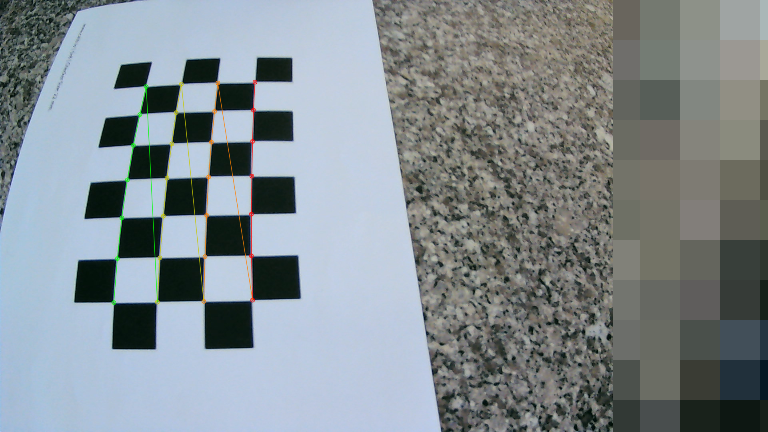

In [9]:
# prepare object points (i.e., real world points)
objp = np.zeros((4*7,3), np.float32)  
objp[:,:2] = (SQUARE_SIZE*np.mgrid[0:7,0:4]).T.reshape(-1,2)

# arrays to store object points and image points from all the images
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane

# termination criteria for the cv.cornerSubPix() function
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

for fname in images_intrinsic:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (7,4), None)
    # if found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        # draw and display the corners
        cv.drawChessboardCorners(img, (7,4), corners2, ret)
        #cv2_imshow(img)

# just show "draw and display the corners" on the last image
small_img = cv.resize(img, (0,0), fx=0.4, fy=0.4)
cv2_imshow(small_img)

`calibrateCamera()` function finds the camera **intrinsic** and **extrinsic** parameters from several views of a calibration pattern.

The algorithm performs the following steps:

* Compute the initial intrinsic parameters (the option only available for planar calibration patterns) or read them from the input parameters. The distortion coefficients are all set to zeros initially unless some of `CALIB_FIX_K?` are specified.

* Estimate the initial camera pose as if the intrinsic parameters have been already known. This is done using `solvePnP()`.

* Run the global Levenberg-Marquardt optimization algorithm to minimize the reprojection error, that is, the total sum of squared distances between the observed feature points imagePoints and the projected (using the current estimates for camera parameters and the poses) object points objectPoints.

From: <https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d>

In [10]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [11]:
print('camera matrix (or intrinsic matrix) \n', mtx, '\n')
print('distortion coefficients \n', dist)

camera matrix (or intrinsic matrix) 
 [[1.32164964e+03 0.00000000e+00 9.88299720e+02]
 [0.00000000e+00 1.32444624e+03 6.42259045e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 

distortion coefficients 
 [[-3.44269868e-01  9.00566925e-02  9.45446381e-05 -3.97945884e-04
  -3.15663097e-03]]


In [12]:
#print('rotation vectores \n', rvecs, '\n')
#print('translation vectors \n', tvecs)

**Reprojection Error**

`calibrateCamera()` function returns the overall RMS reprojection error.

From: <https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d>

In [13]:
# overall root mean squared (RMS) reprojection error
print('RMS reprojection error:', ret)

RMS reprojection error: 0.49167717469524697


The reprojection error is a geometric error corresponding to the image distance between a projected point and a measured one.

From: <https://en.wikipedia.org/wiki/Reprojection_error>

Reprojection error gives a good estimation of just how exact the found parameters are. The closer the reprojection error is to zero, the more accurate the parameters we found are.

Given the intrinsic, distortion, rotation and translation matrices, we must first transform the object point to image point using `cv.projectPoints()`. Then, we can calculate the absolute norm between what we got with our transformation and the corner finding algorithm. To find the average error, we calculate the arithmetical mean of the errors calculated for all the calibration images.

*Reference*: <https://docs.opencv.org/4.5.3/dc/dbb/tutorial_py_calibration.html> (see the bottom of the page).

In [14]:
# Mean Reprojection Error
# and RMS Reprojection Error (to confirm)

sum_error = 0
sum_squared_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    for j in range(len(imgpoints2)):
        error = cv.norm(imgpoints[i][j], imgpoints2[j], cv.NORM_L2) # reprojection erro (using the Euclidean distance)
        sum_error += error
        sum_squared_error += error**2

print( 'Mean reprojection error: {}'.format(sum_error/(len(imgpoints2)*len(objpoints))) )
print( 'RMS reprojection error: {}'.format((sum_squared_error/(len(imgpoints2)*len(objpoints)))**(1/2)) )

Mean reprojection error: 0.40006697358652776
RMS reprojection error: 0.49167707772305735


## **b)** Calibration of the extrinsic parameters of the camera setup.

**Extrinsic parameters** correspond to rotation and translation vectors which translate coordinates of a 3D point to a 2D coordinate system.

From: <https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html>

For this part of the assignment, we will be using the chess board image in the white background folder, as we assume that all images in this folder were produced with the camera in a **static position** (as shown in Figure 1 of the assignment).

In [15]:
whiteb_extrinsic = cv.imread('./Data/WhiteBackground/extrinsic.png')

In [16]:
gray_ext = cv.cvtColor(whiteb_extrinsic, cv.COLOR_BGR2GRAY)
# find the chess board corners
ret_ext, corners_ext = cv.findChessboardCorners(gray_ext, (7,4), None)
# refine the chess board corners
corners2_ext = cv.cornerSubPix(gray_ext, corners_ext, (11,11), (-1,-1), criteria)

In [17]:
# prepare object points (i.e., real world points)
objp = np.zeros((4*7,3), np.float32)  
objp[:,:2] = (SQUARE_SIZE*np.mgrid[0:7,0:4]).T.reshape(-1,2)
# determine rotation vector and translation vector
sucess, rvec_ext, tvec_ext = cv.solvePnP(objp, corners2_ext, mtx, dist)
print("sucess?", sucess)
print("\nrotation vectores \n", rvec_ext)
print("\ntranslation vectors \n", tvec_ext)

sucess? True

rotation vectores 
 [[-0.00383021]
 [ 0.02256792]
 [ 3.13820054]]

translation vectors 
 [[ 71.00528094]
 [ -3.47044008]
 [227.45935239]]


Place an axis on the image using the extrinsic calibration.

From: <https://docs.opencv.org/3.4/d7/d53/tutorial_py_pose.html>

In [18]:
axis = np.float32([[21,0,0], [0,21,0], [0,0,-21]]).reshape(-1,3) # to occupy the side of a square

In [19]:
imgpts_ext, jac_ext = cv.projectPoints(axis, rvec_ext, tvec_ext, mtx, dist)

In [20]:
def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    img = cv.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
    img = cv.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
    img = cv.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
    return img

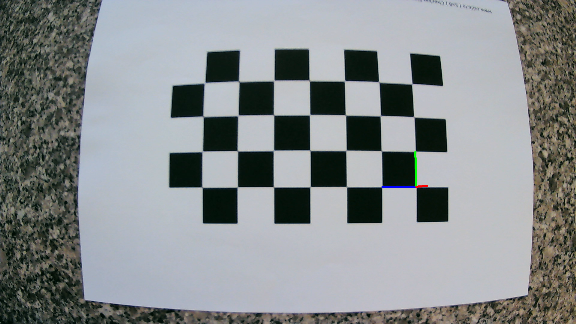

In [21]:
img_axis = whiteb_extrinsic.copy()
img_axis = draw(img_axis, corners2_ext, imgpts_ext)
small_img_axis = cv.resize(img_axis, (0,0), fx=0.3, fy=0.3)
cv2_imshow(small_img_axis)

**Conversion pixel-millimeter**

*Recall*: The side of each square is 21mm.

* In the **distorted** image, the number of pixels that correspond to the side of a square depends on the square location on the image. In this case, we have a *barrel distortion*, so squares at the center occupy more pixels than the ones on the edges.

* However, in the **undistorted** image, we should have consistency in the number of pixels that correspond to the side of a square.

Undistort the image and crop.

From: <https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html>

In [22]:
h, w = whiteb_extrinsic.shape[:2]
newcameramtx_und, roi_und = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

In [23]:
def own_undistort(img, mtx, dist):
    # undistort
    dst = cv.undistort(img, mtx, dist, None, newcameramtx_und)
    # crop the image
    x, y, w, h = roi_und
    dst = dst[y:y+h, x:x+w]
    return dst

(775, 1663, 3)


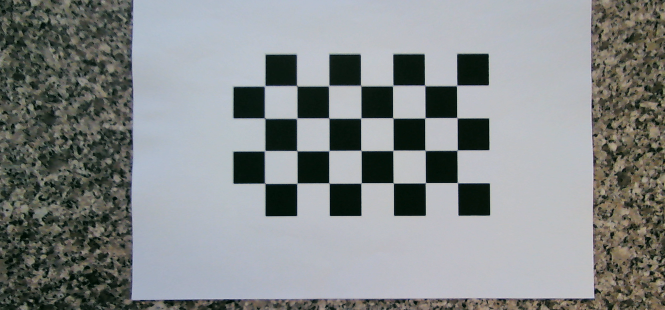

In [24]:
und_extrinsic = own_undistort(whiteb_extrinsic, mtx, dist)
print(und_extrinsic.shape)
small_und_extrinsic = cv.resize(und_extrinsic, (0,0), fx=0.4, fy=0.4)
cv2_imshow(small_und_extrinsic)

In [25]:
gray_und = cv.cvtColor(und_extrinsic, cv.COLOR_BGR2GRAY)
# find the chess board corners
ret_und, corners_und = cv.findChessboardCorners(gray_und, (7,4), None)
# refine the chess board corners
corners2_und = cv.cornerSubPix(gray_und, corners_und, (11,11), (-1,-1), criteria)
print(corners2_und[:,0])

[[1144.1752   457.18997]
 [1063.8672   457.4871 ]
 [ 983.76196  457.87296]
 [ 903.4434   458.20035]
 [ 823.2684   458.33432]
 [ 743.20166  458.54187]
 [ 662.5986   458.85416]
 [1143.5076   375.97406]
 [1063.2002   376.2612 ]
 [ 983.244    376.51837]
 [ 903.0341   376.62656]
 [ 823.07184  376.98267]
 [ 742.76434  377.2315 ]
 [ 662.4157   377.30176]
 [1142.9214   294.73843]
 [1062.889    295.10043]
 [ 982.96027  295.50235]
 [ 902.7691   295.69693]
 [ 822.61127  295.87643]
 [ 742.7378   295.93707]
 [ 662.352    296.12155]
 [1142.3937   214.08766]
 [1062.258    214.16803]
 [ 982.62164  214.35823]
 [ 902.54584  214.7099 ]
 [ 822.41986  214.66194]
 [ 742.5199   214.83392]
 [ 662.44965  215.16122]]


From the above coordinates, we can see that, in this undistorted image, the detected corners are almost perfectly aligned. Thus, the difference between its coordinates should give the same values, which is the number of pixels that corresponds to the side of a square.

In [26]:
x = [np.mean([corners2_und[:,0][i][0] for i in [0+j, 7+j, 14+j, 21+j]]) for j in range(0,7)]
y = [np.mean([corners2_und[:,0][i][1] for i in range(j,j+7)]) for j in range(0,22,7)]

px_mm_square = np.mean([x[i]-x[i+1] for i in range(0,6)])*(len(x)-1)/(len(x)-1+len(y)-1) + np.mean([y[i]-y[i+1] for i in range(0,3)])*(len(y)-1)/(len(x)-1+len(y)-1)
print('The side of a square, which is 21mm, corresponds to approximately', round(px_mm_square, 1), 'pixels in the undistorted image.')
px_mm = SQUARE_SIZE/px_mm_square
print('Thus, 1 px =', round(px_mm, 6), 'mm.')
area_pixel = px_mm**2
print('Therefore, the area of 1 pixel is', round(area_pixel, 6), 'mm².')

The side of a square, which is 21mm, corresponds to approximately 80.5 pixels in the undistorted image.
Thus, 1 px = 0.260943 mm.
Therefore, the area of 1 pixel is 0.068091 mm².


The equivalence obtained (i.e., 1 pixel approximatly 0.26 millimeters) is in line with the standard equivalence.

From: https://en.wikipedia.org/wiki/Pixel#:~:text=Pixels%2C%20abbreviated%20as%20%22px%22,mm)

In [27]:
# alternative process to determine px_mm_square using the euclidean distance between two adjacent corners
dist_corners = []
for i in range(27):
    if i not in [6, 13, 20]:
        dist_corners.append(cv.norm(corners2_und[i,0], corners2_und[i+1,0], cv.NORM_L2))
for i in range(21):
    dist_corners.append(cv.norm(corners2_und[i,0], corners2_und[i+7,0], cv.NORM_L2))
print('Using the alternative process, the side of a square, which is 21mm, corresponds to approximately', round(sum(dist_corners)/len(dist_corners), 1), 'pixels in the undistorted image.')

Using the alternative process, the side of a square, which is 21mm, corresponds to approximately 80.6 pixels in the undistorted image.


## **c)** Considering only the images retrieved from a **White Background**:

As stated previously, we assume all images in the WhiteBackground folder were produced with the camera in the same static position and that the white background (i.e., the white sheet of paper) does not change place.

### **I.** Define a ROI (region of interest);

In this case, the ROI will be the white sheet of paper. To determine the mask for the ROI, the best image to use is `calib_img 0.png`, which only has the white sheet of paper (without M&M on top of it).

We began by applying the medium blur filter to reduce reflexes and shadows.

In [28]:
images_calib_x = glob.glob('./Data/WhiteBackground/calib_img*.png') 
images_calib = sorted(images_calib_x)

In [29]:
images_corrected = []               # this list stores the images undistorted and with medianBlur filter applied  
for fname in images_calib:
    img = cv.imread(fname)
    img = cv.medianBlur(img,9)
    img = own_undistort(img, mtx, dist)
    img = cv.resize(img, (0,0), fx=fx_resize, fy=fy_resize)             
    #cv2_imshow(img)  
    #print("\n")
    images_corrected.append(img)

#### **Approach 1.**

First atempt: <br>
* Try to remove the pixels different from white (sheet color) with adjustment of sensibility. <br> 
* The adjustment was made keeping the ranges of the white color in HSV. <br> 
* It didn't work very weel so we try another approach 


In [30]:
"""
for img in images_corrected:
  img = cv.medianBlur(img,9)
  img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
  #cv2_imshow(img)
  #print("\n")

  # white
  sensitivity = 100
  lower_white = (0,0,255-sensitivity)
  upper_white = (255,sensitivity,255)
  mask_white = cv.inRange(img_hsv, lower_white, upper_white)
  mask_image = cv.bitwise_and(img_hsv, img_hsv, mask=mask_white)
  img_white = cv.cvtColor(mask_image, cv.COLOR_HSV2BGR)
  #cv2_imshow(img_white)
  #print("\n")
  break

# Apply the mask from the 1st image to the others and remove the granite from the images 
images_roi_defined = []    
images_corrected.pop(0)  # removes the 1st image that only has the sheet of paper        

for img in images_corrected:
  img = cv.bitwise_and(img,img,mask = mask_white)   
  images_roi_defined.append(img)
  #cv2_imshow(img)
  #print("\n")

""";

#### **Approach 2.**

* Alternative using binary image.
* This was the choosen approach.

In [31]:
# Load image
img = images_corrected[0].copy()
#cv2_imshow(img)
#print("\n")

# Convert to grayscale
gray = cv.cvtColor(img,cv.COLOR_RGB2GRAY)
gray = cv.medianBlur(gray,9)
# Convert to binary
threshold, max_value = 165, 255
binary = cv.threshold(gray, threshold, max_value, cv.THRESH_BINARY)[1]

kernel = np.ones((15, 15), 'uint8')
binary = cv.erode(binary, kernel, iterations=3)
#cv2_imshow(binary)
#print("\n")

images_roi_defined = []    
images_corrected.pop(0)             # remove 1st image because does not have M&M          
for img in images_corrected:
  img = cv.bitwise_and(img,img,mask = binary)   
  img = cv.medianBlur(img,9)        # new iteration to remove the shadows 
  images_roi_defined.append(img)
  #cv2_imshow(img)
  #print("\n")

### **II.** Calculate the color distribution (up to 4);

* The histogram is a graphical representation of the pixel intensity distribution of each channel of an image.
* We considered the HSV color model to plot the histograms.
* As can be seen below, the Hue histograms are useful to adjust the color ranges (defined in the following cell), in order to filter the colors with more precision.
* In the outputs generated, it is also shown the percentage of color in each channel of BGR model.




In [32]:
# color ranges
# red low
lower_red, upper_red = (0, 100, 100), (10, 255, 255)
# red high
lower_red_h, upper_red_h = (150, 100, 100), (179, 255, 255)
# green
lower_green, upper_green = (35,50,60), (90,255,255)
# blue
lower_blue, upper_blue = (90,100,60), (120,255,255)
# yellow
lower_yellow, upper_yellow = (20,100,100), (35,255,255)
# brown 
lower_brown, upper_brown = (10, 100, 20), (20, 255, 200)

In [33]:
images_only_with_MandM = []
masks_data = []                         # tuple with masks for each image (Red Mask, Green Mask, Blue Mask, Yellow Mask)
masks_combined_data = []                # list with mask of all m&m (independent of color)

for img in images_roi_defined:
  img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
  #cv2_imshow(img)
  #print("\n")

  # Red
  mask_red_low = cv.inRange(img_hsv, lower_red, upper_red)
  mask_red_high = cv.inRange(img_hsv, lower_red_h, upper_red_h)
  # combine masks
  mask_red = cv.bitwise_or(mask_red_low, mask_red_high) 
  #img_red = cv.bitwise_or(img_hsv, img_hsv, mask=mask_red)
  #cv2_imshow(img_red)

  # green
  mask_green = cv.inRange(img_hsv, lower_green, upper_green)
  #img_green = cv.bitwise_and(img_hsv, img_hsv, mask=mask_green)
  #cv2_imshow(img_green)

  # blue
  mask_blue = cv.inRange(img_hsv, lower_blue, upper_blue)
  #img_blue = cv.bitwise_and(img_hsv, img_hsv, mask=mask_blue)
  #cv2_imshow(img_blue)

  # yellow
  mask_yellow = cv.inRange(img_hsv, lower_yellow, upper_yellow)
  #img_yellow = cv.bitwise_and(img_hsv, img_hsv, mask=mask_yellow)
  #cv2_imshow(img_yellow)

  combined_masks = cv.bitwise_or(mask_blue, mask_red)
  combined_masks = cv.bitwise_or(combined_masks, mask_yellow) 
  combined_masks = cv.bitwise_or(combined_masks, mask_green)

  img_roi = cv.bitwise_and(img_hsv, img_hsv, mask=combined_masks)
  img_roi_bgr = cv.cvtColor(img_roi, cv.COLOR_HSV2BGR)
  #cv2_imshow(img_roi_bgr)
  #print("\n")

  masks_data.append((mask_red,mask_green,mask_blue,mask_yellow))
  images_only_with_MandM.append(img_roi_bgr) 
  masks_combined_data.append(combined_masks)


Image 1

Percentage of color in each channel using BGR model
Red: [33.99]% ; Green: [39.17]% ; Blue: [26.85]%


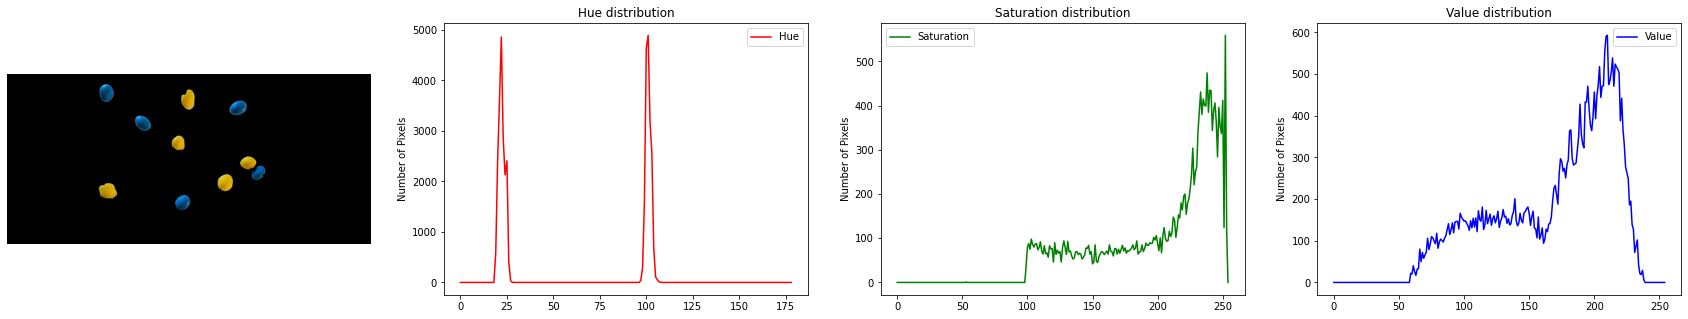

_________________________________________________________________________________________________________________________________


Image 2

Percentage of color in each channel using BGR model
Red: [33.84]% ; Green: [37.22]% ; Blue: [28.94]%


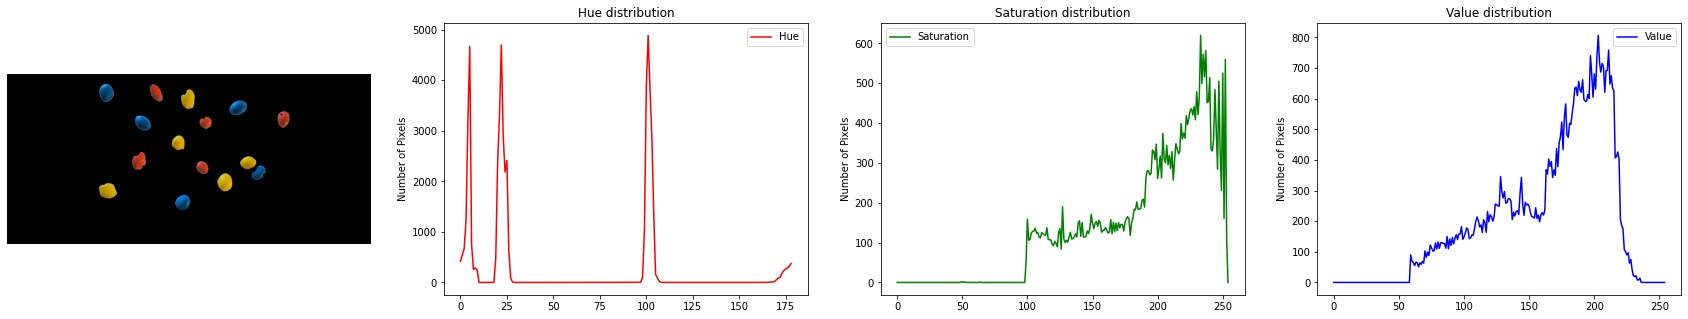

_________________________________________________________________________________________________________________________________


Image 3

Percentage of color in each channel using BGR model
Red: [33.66]% ; Green: [36.39]% ; Blue: [29.95]%


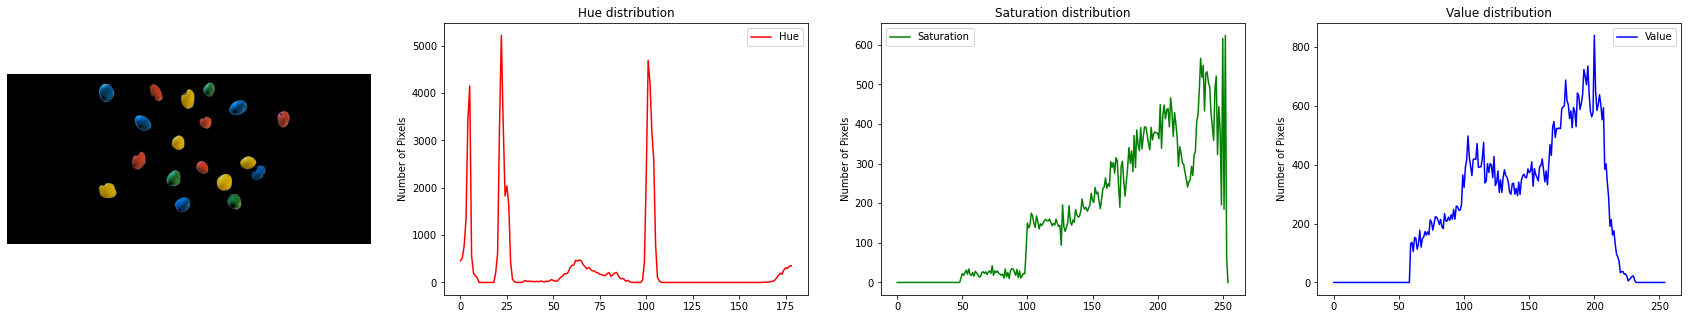

_________________________________________________________________________________________________________________________________



In [34]:
def color_dist(list_of_images_with_roi_defined):
  color = ('b','g','r')
  img_num = 1

  for img_roi_bgr in list_of_images_with_roi_defined:
    qtdBlue = 0
    qtdGreen = 0
    qtdRed = 0
    totalPixels = 0
    for channel,col in enumerate(color):
      histr = cv.calcHist([img_roi_bgr],[channel],None,[256],[1,256])

      totalPixels+=sum(histr)
      if channel==0:
        qtdBlue = sum(histr)
      elif channel==1:
        qtdGreen = sum(histr)
      elif channel==2:
        qtdRed = sum(histr)
    
    qtdBlue = (qtdBlue/totalPixels)*100
    qtdGreen = (qtdGreen/totalPixels)*100
    qtdRed = (qtdRed/totalPixels)*100

    print("\nImage", img_num)
    img_num += 1
    print("\nPercentage of color in each channel using BGR model")
    print("Red: "+str(np.round(qtdRed,2))+"% ; Green: "+str(np.round(qtdGreen,2))+"% ; Blue: "+str(np.round(qtdBlue,2))+"%")

    ### Now in hsv plot the values of each component of the image

    img2 = cv.cvtColor(img_roi_bgr, cv.COLOR_BGR2HSV)
    h, s, v = img2[:,:,0], img2[:,:,1], img2[:,:,2]
    hist_h = cv.calcHist([h],[0],None,[179],[1,180])
    hist_s = cv.calcHist([s],[0],None,[255],[1,255]) # 256 removed, so that the peak for black is no shown (in alternativa a mask could be inserted in place of "None")
    hist_v = cv.calcHist([v],[0],None,[255],[1,256])

    w, h = 30, 5
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(w, h))
    img_roi_rgb = cv.cvtColor(img_roi_bgr, cv.COLOR_BGR2RGB)
    ax[0].imshow(img_roi_rgb)
    ax[0].axis('off')
    ax[1].plot(hist_h, color='r', label="Hue")
    ax[1].set_ylabel("Number of Pixels")
    ax[1].set_title("Hue distribution")
    ax[1].legend()
    ax[2].plot(hist_s, color='g', label="Saturation")
    ax[2].set_ylabel("Number of Pixels")
    ax[2].set_title("Saturation distribution")
    ax[2].legend()
    ax[3].plot(hist_v, color='b', label="Value")
    ax[3].set_ylabel("Number of Pixels")
    ax[3].set_title("Value distribution")
    ax[3].legend()
    plt.show()

    print("_________________________________________________________________________________________________________________________________\n")

color_dist(images_only_with_MandM)

### **III**. Determine the shape area for the chocolate peanuts in pixels;

The area are obtained by the count of white pixels in the mask (binary mask).

In [35]:
for image_index, i in enumerate(masks_combined_data):
  print("Total shape area in pixel of chocolate peanuts in image {} = {}".format(image_index+1, np.int(np.sum(i)/255)))

Total shape area in pixel of chocolate peanuts in image 1 = 37353
Total shape area in pixel of chocolate peanuts in image 2 = 51910
Total shape area in pixel of chocolate peanuts in image 3 = 60352


### **IV**. Determine the shape area for chocolate peanuts in millimeters and group by color;

The area are obtained by the count of the " global" mask of each image. The global mask is generated by an OR operation between the masks of each color. <br>
maks_data = [(Mask_R_img0,Mask_G_img0,Mask_B_img0,Mask_Y_img0),...,(Mask_R_imgn,Mask_G_imgn,Mask_B_imgn,Mask_Y_imgn)] <br>
maks_data_combined = [combined_by_OR_masks_img0,...,combined_by_OR_masks_imgn] <br>
Due to this approach the number of pixel in the maks_data_combined can be a slightly smaller than the sum of each separated mask 



In [36]:
def shape_area_color (colors_MandM, masks_data_list):
  for img_nr, i in enumerate(masks_data_list): 
    vals = [] # value of each color for bar plot
    print("Image", img_nr+1)
    for nr, j in enumerate(i):
      vals.append((np.sum(j)/255)*area_pixel)        
      print("Area of {} (in mm²) = {}".format(colors_MandM[nr], np.round((np.sum(j)/255)*area_pixel,2)))
    print("\n") 

    fig = plt.figure(figsize=(8,5))
    plt.bar(colors_MandM, vals, color=colors_MandM)
    plt.ylabel("Area of each color (mm²)")
    plt.title('Area of each color in image {}'.format(img_nr))
    plt.show()

    print("---------------------------------------------------------------\n")   


Image 1
Area of Red (in mm²) = 0.0
Area of Green (in mm²) = 0.07
Area of Blue (in mm²) = 1230.96
Area of Yellow (in mm²) = 1312.39




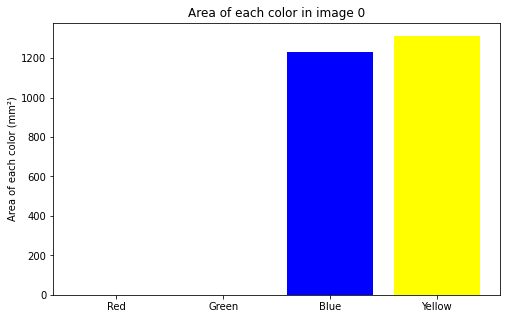

---------------------------------------------------------------

Image 2
Area of Red (in mm²) = 992.98
Area of Green (in mm²) = 0.34
Area of Blue (in mm²) = 1241.1
Area of Yellow (in mm²) = 1300.21




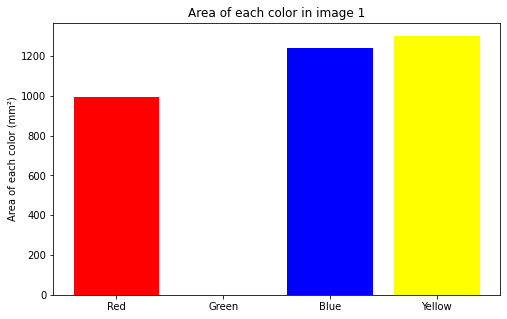

---------------------------------------------------------------

Image 3
Area of Red (in mm²) = 972.41
Area of Green (in mm²) = 609.35
Area of Blue (in mm²) = 1257.58
Area of Yellow (in mm²) = 1271.74




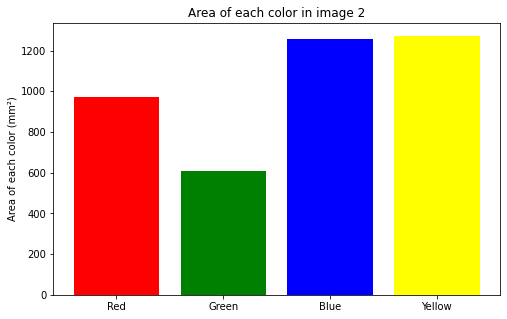

---------------------------------------------------------------



In [37]:
colors = ['Red', 'Green', 'Blue', 'Yellow']
shape_area_color(colors, masks_data)

### **V**. Show a histogram of the shape areas of the chocolate peanuts for the entire sample;

For this task, we will be working with the **entire sample image**, therefore image `calib_img 3.png`.

**The steps to complete the task of obtaining the histogram of the shape areas are:**
0. Show the images to be used;

1. Apply connected component labeling to the mask of the entire sample image;

2. Join the residual labels to the adjacent significant label, obtaining a new set of labels;

3. Apply morphological operations to each of the new labels separately;

4. Determine the area and assign an M&M color (i.e., blue, yellow, red, green, brown) to each new label;

5. Plot the histogram.

Step 1 assigns a label to each componente detected. However, some labeled components are part of a larger component. Step 2 corrects this labeling problem. Step 3 ensures that **different** M&M will **not** be joined together with the morphological operations needed to remove the holes caused by the reflexes.

#### Step0

Entire sample image (undistorted):


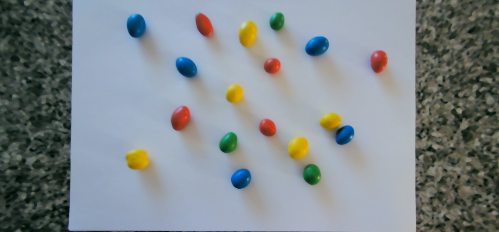

(775, 1663, 3) ; uint8

Entire sample image with mask:


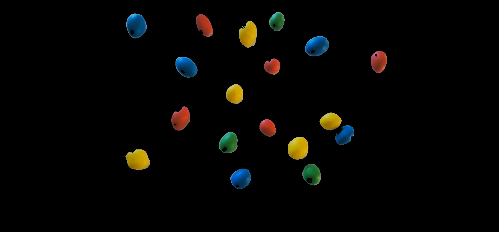

(775, 1663, 3) ; uint8

Mask of entire sample image:


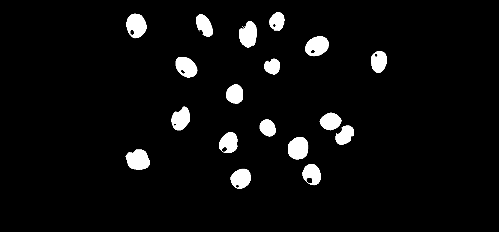

(775, 1663) ; uint8


In [38]:
index_img = 2
entire_sample_image = images_corrected[index_img].copy()
entire_sample_image_with_mask = images_only_with_MandM[index_img].copy()
mask_of_entire_sample_image = masks_combined_data[index_img].copy()

def show_images(entire_sample_image, entire_sample_image_with_mask, mask_of_entire_sample_image):
  # just to plot the image with a smaller size
  small_entire_sample_image = cv.resize(entire_sample_image, (0,0), fx=0.30, fy=0.30)
  small_entire_sample_image_with_mask = cv.resize(entire_sample_image_with_mask, (0,0), fx=0.30, fy=0.30)
  small_mask_of_entire_sample_image = cv.resize(mask_of_entire_sample_image, (0,0), fx=0.30, fy=0.30)
  print('Entire sample image (undistorted):')
  cv2_imshow(small_entire_sample_image)
  print(entire_sample_image.shape, ';', entire_sample_image.dtype)
  print()
  print('Entire sample image with mask:')
  cv2_imshow(small_entire_sample_image_with_mask)
  print(entire_sample_image_with_mask.shape, ';', entire_sample_image_with_mask.dtype)
  print()
  print('Mask of entire sample image:')
  cv2_imshow(small_mask_of_entire_sample_image)
  print(mask_of_entire_sample_image.shape, ';', mask_of_entire_sample_image.dtype)

show_images(entire_sample_image, entire_sample_image_with_mask, mask_of_entire_sample_image)

In [39]:
# function to color the labels of the connected components

def imshow_components(labels):

    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv.cvtColor(labeled_img, cv.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    plt.figure(figsize = (15,15))
    plt.imshow(labeled_img)

#### Step1

(775, 1663) ; int32


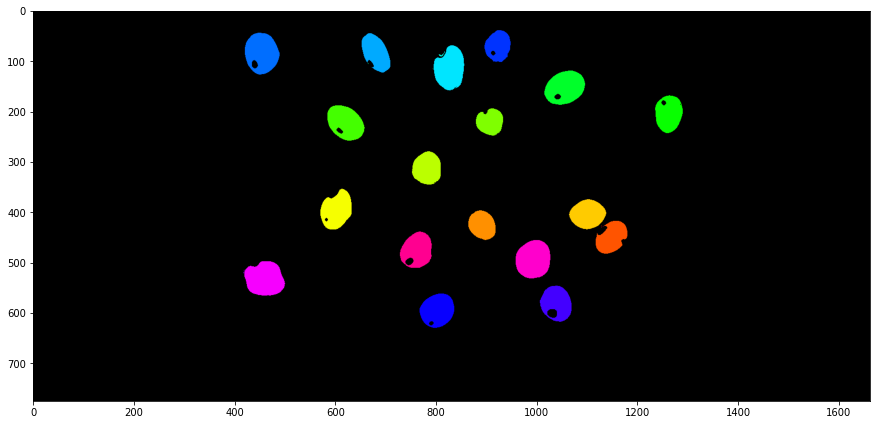

In [40]:
# STEP 1: Apply connected component labeling to the mask of the entire sample image

def step1():
  num_labels, labels_im = cv.connectedComponents(mask_of_entire_sample_image)
  imshow_components(labels_im)
  print(labels_im.shape, ';', labels_im.dtype)

  return num_labels, labels_im

num_labels, labels_im = step1()

In [41]:
def step2(num_labels, labels_im, threshold_label):
# STEP 2: Join the residual labels to the adjacent significant label, obtaining a new set of labels
# label == 0 is the background (as it is the first component detected when the 
# search starts from the top left corner of the image)
# labels with small counts have to joined to the previous label with big count
# a count is considered big if it is larger than the threshold_label

  print('Count labels:', num_labels)
  unique, counts = np.unique(labels_im, return_counts=True)
  print(np.asarray((unique, counts)).T, "\n")
  
  label_groups = []
  for i in range(len(unique)):
      if counts[i] >= threshold_label:
          one_group = []
          one_group.append(i)
          label_groups.append(one_group)
      else:
          one_group.append(i)

  print('Count NEW labels:', len(label_groups))
  print(label_groups)
  return label_groups

label_groups = step2(num_labels, labels_im, threshold_label = 100)

Count labels: 27
[[      0 1228473]
 [      1    2419]
 [      2    4217]
 [      3    2968]
 [      4    3987]
 [      5      30]
 [      6       2]
 [      7       1]
 [      8    4039]
 [      9    3102]
 [     10    3762]
 [     11    2204]
 [     12    2973]
 [     13    3568]
 [     14    3202]
 [     15    2437]
 [     16    2847]
 [     17       1]
 [     18       2]
 [     19       1]
 [     20    3352]
 [     21    4230]
 [     22    4285]
 [     23       2]
 [     24       3]
 [     25    3177]
 [     26    3541]] 

Count NEW labels: 19
[[0], [1], [2], [3], [4, 5, 6, 7], [8], [9], [10], [11], [12], [13], [14], [15], [16, 17, 18, 19], [20], [21], [22, 23, 24], [25], [26]]


#### Step3

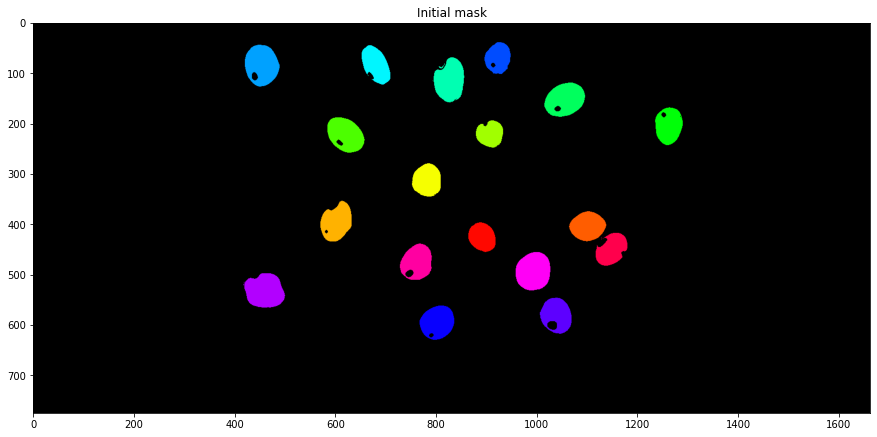

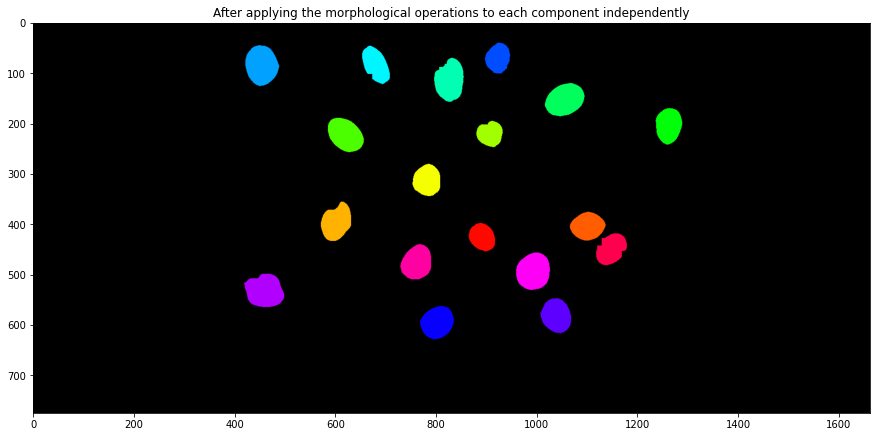

In [42]:
# STEP 3: Apply morphological operations to each of the new labels separately

def step3(labels_im, label_groups, k2):
  label_im_set = []
  morphological_operation_step5_set = []
  final_masks = []

  for k in range(1,len(label_groups)):
      labels_im_select = labels_im.copy()
      # select one component and rearrange the label
      for i in range(0, labels_im_select.shape[0]):
          for j in range(0, labels_im_select.shape[1]):
              if labels_im_select.item(i,j) not in label_groups[k]:
                  labels_im_select.itemset((i, j), 0)
              else:
                  labels_im_select.itemset((i, j), 255)
      # apply morphological operations to that component
      labels_im_select = labels_im_select.astype(np.uint8)
      morphological_operation_step0 = labels_im_select.copy()
      # closing to close the holes
      kernel1 = np.ones((15, 15), 'uint8')  ## the kernel size can be changed
      morphological_operation_step1 = cv.dilate(morphological_operation_step0, kernel1, iterations=1)
      morphological_operation_step2 = cv.erode(morphological_operation_step1, kernel1, iterations=1)
      # opening to remove noise
      kernel2 = np.ones((k2, k2), 'uint8')  ## the kernel size can be changed
      morphological_operation_step3 = cv.erode(morphological_operation_step2, kernel2, iterations=1)
      morphological_operation_step4 = cv.dilate(morphological_operation_step3, kernel2, iterations=1)
      # fine tuning
      kernel3 = np.ones((3, 3), 'uint8')  ## the kernel size can be changed
      morphological_operation_step5 = cv.erode(morphological_operation_step4, kernel3, iterations=1)
      # store final masks
      final_masks.append(morphological_operation_step5)
      # reintroduce sequential labels
      for i in range(0, labels_im_select.shape[0]):
          for j in range(0, labels_im_select.shape[1]):
              if labels_im_select.item(i,j) == 255:
                  labels_im_select.itemset((i, j), k)
      for i in range(0, morphological_operation_step5.shape[0]):
          for j in range(0, morphological_operation_step5.shape[1]):
              if morphological_operation_step5.item(i,j) == 255:
                  morphological_operation_step5.itemset((i, j), k)
      # store results
      label_im_set.append(labels_im_select)
      morphological_operation_step5_set.append(morphological_operation_step5)

  # join all components
  initial_label_im = sum(label_im_set)
  final_label_im = sum(morphological_operation_step5_set)

  # before and after images
  imshow_components(initial_label_im.astype(np.uint32))
  plt.title('Initial mask')
  imshow_components(final_label_im.astype(np.uint32))
  plt.title('After applying the morphological operations to each component independently');
  return final_masks

final_masks = step3(labels_im, label_groups, k2=3)

#### Step4

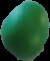

M&M 0
area: 153.82 mm²
color: green



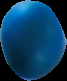

M&M 1
area: 276.72 mm²
color: blue



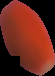

M&M 2
area: 183.51 mm²
color: red



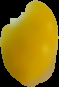

M&M 3
area: 257.93 mm²
color: yellow



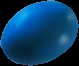

M&M 4
area: 262.02 mm²
color: blue



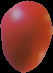

M&M 5
area: 192.97 mm²
color: red



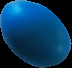

M&M 6
area: 243.22 mm²
color: blue



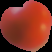

M&M 7
area: 134.34 mm²
color: red



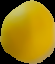

M&M 8
area: 186.09 mm²
color: yellow



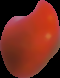

M&M 9
area: 223.2 mm²
color: red



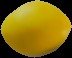

M&M 10
area: 200.05 mm²
color: yellow



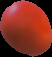

M&M 11
area: 147.62 mm²
color: red



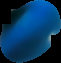

M&M 12
area: 189.02 mm²
color: blue



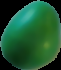

M&M 13
area: 222.66 mm²
color: green



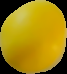

M&M 14
area: 268.55 mm²
color: yellow



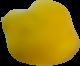

M&M 15
area: 273.52 mm²
color: yellow



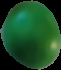

M&M 16
area: 216.67 mm²
color: green



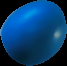

M&M 17
area: 226.47 mm²
color: blue



In [43]:
def step4():  
  # STEP 4: Determine the area and assign an M&M color (i.e., blue, yellow, red, green, brown) to each new label

  info_peanuts = []           # [component, area_peanut_px, area_peanut_px_count, area_peanut_mm, color_peanut]

  for i in range(0,len(final_masks)):
      mask_in_use = final_masks[i]
      img_mask = cv.bitwise_and(entire_sample_image, entire_sample_image, mask = mask_in_use)
      contour, _ = cv.findContours(mask_in_use, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
      # crop the image
      x, y, w, h = cv.boundingRect(contour[0]) # determine the bounding box
      img_mask_roi = img_mask[y:y+h,x:x+w,:] # crop by the bounding box
      # determine the color
      img_mask_roi_hsv = cv.cvtColor(img_mask_roi, cv.COLOR_BGR2HSV) # convert to hsv
      img_mask_roi_h = cv.split(img_mask_roi_hsv)[0] # retain only the H-channel
      color_peanut_std = np.ma.masked_where(img_mask_roi_h==0, img_mask_roi_h).std() # because red is a problem
      # determine the area
      area_peanut_px = cv.contourArea(contour[0]) # area in px using contourArea() function (gives an estimate)
      area_peanut_px_count = np.ma.masked_where(img_mask_roi_h==0, img_mask_roi_h).count() # area in px by counting pixels
      area_peanut_mm = area_peanut_px_count*area_pixel      
      if color_peanut_std > 25:
          color_peanut = 'red'
      else:
          color_peanut_mean = np.ma.masked_where(img_mask_roi_h==0, img_mask_roi_h).mean()
          if (color_peanut_mean > lower_yellow[0]) and (color_peanut_mean < upper_yellow[0]):
              color_peanut = 'yellow'
          elif (color_peanut_mean > lower_blue[0]) and (color_peanut_mean < upper_blue[0]):
              color_peanut = 'blue'
          elif (color_peanut_mean > lower_green[0]) and (color_peanut_mean < upper_green[0]):
              color_peanut = 'green'
          else:
              color_peanut = 'brown'       
      info_peanuts.append([i, area_peanut_px, area_peanut_px_count, np.round(area_peanut_mm,2), color_peanut])
      cv2_imshow(img_mask_roi)
      print('M&M', i) 
      print('area:', np.round(area_peanut_mm,2), 'mm²')
      print('color:', color_peanut)
      print()
  return info_peanuts

info_peanuts = step4()

`Component` is the M&M number identification;

`area_peanut_px` is the area of the M&M measured using the `contourArea()` function, which gives an estimate of the number of pixels occupied by the contour defined shape;

`area_peanut_px_count` is the area of the M&M measured by actually counting the pixels within the bounding box which are not black;

`area_peanut_mm` is the area of the M&M given by the product between area_peanut_px_count and the area_pixel determined in b).

`color_peanut` is the color of M&M, determined using statistics of the H-channel of the image.

The color could have been be determined using the independent masks. The process used here was an experiment to see how the assignment of color could be done if only the combined mask was provided (and not the individual masks).

#### Step5

  Component    area_peanut_px    area_peanut_px_count    area_peanut_mm  color_peanut
-----------  ----------------  ----------------------  ----------------  --------------
          0            2181.5                    2259            153.82  green
          1            3961                      4064            276.72  blue
          2            2665                      2695            183.51  red
          3            3680.5                    3788            257.93  yellow
          4            3747.5                    3848            262.02  blue
          5            2827.5                    2834            192.97  red
          6            3475                      3572            243.22  blue
          7            1947                      1973            134.34  red
          8            2647.5                    2733            186.09  yellow
          9            3232                      3278            223.2   red
         10            2852.5                

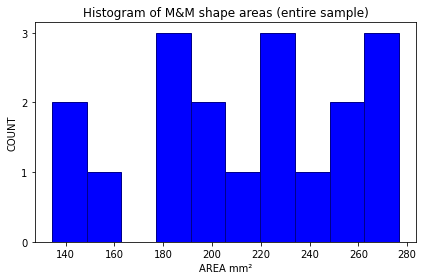

In [44]:
def step5(info_peanuts):
  # STEP 5: Plot the histogram

  table = pd.DataFrame(info_peanuts, columns=['Component', 'area_peanut_px', 'area_peanut_px_count', 'area_peanut_mm', 'color_peanut'])
  print(tabulate(table, showindex=False, headers=table.columns), "\n")

  data_hist = [info_peanuts[i][3] for i in range(len(info_peanuts))]
  fig, ax = plt.subplots(tight_layout=True)
  ax.hist(data_hist, color = 'blue', edgecolor = 'darkblue')
  ax.yaxis.get_major_locator().set_params(integer=True)
  plt.title('Histogram of M&M shape areas (entire sample)')
  plt.xlabel('AREA mm²') 
  plt.ylabel('COUNT')
  plt.show()

step5(info_peanuts)

Following this five steps approach we can separate each M&M and group by color. Because these masks were corrected for the holes caused by the reflexions and shadows, the areas now calculated are more reliable.

### **VI**. Provide some recommendations that the M&M factory should take into consideration to improve the performance of the quality assurance process based on image processing (e.g., imaging setup, calibration process and photometric effects).

To provide the recommendations, we first list the main difficulties encountered with the images provided:

* barrel distortion;
* blurred image;
* reflexes and shadows (consequence of the lighting setup);
* background;
* individual objects to detect too closed together.

Recommendations

* Calibration process 
  * barril distortion can be caused by the inappropriate distance to the photographed object in relation to the type of lens used;
  * blur can also be caused by distance to the photographed object;
  * thus, check if the lens is of the appropriate type, if it is focused and clean, and the distance to the object(s) is otimal. 

* Photometric effects
  * lighting is a key factor;
  * thus, consider the use of more than one light source placed at a higher position to avoid shadows; 
  * use polarizer lens to filter shine;
  * isolate the photometric setup from the natural light (e.g. box).

* Imaging setup
  * background with only one color (different from M&M colors), with a lower specular relfexion;
  * the top left corner should be without any object to detect easily the background;
  * the objects should be separated at least to ensure the abstance of shadows. 

These suggestions can reduce or even eliminate some of the processing effort on the images, thus reducing runtime. They also contribute to improving the reliability of results.

## **d)**  Consider the images retrieved from a Grey Background and repeat the previous point without defining a region of interest.

### **d I.** Clean Background;

In [45]:
images_grey_back_0 = glob.glob('./Data/GreyBackground/calib_img *.png')  
images_grey_back_add = sorted(images_grey_back_0)

images_grey_back = []

for fname in images_grey_back_add:
    img_read = cv.imread(fname)
    img_read = own_undistort(img_read, mtx, dist)
    img_read = cv.resize(img_read, (0,0), fx=fx_resize, fy=fy_resize) 
    images_grey_back.append(img_read)

images_grey_back.pop(0)  # removes the 1st image that only has the background
print()

#### **Approach 1.**

Get function that returns only brown mask.

In [46]:
def mask_brown_func (img_read):
  #cv2_imshow(img_read)
  #print("\n")  
  imx = cv.cvtColor(img, cv.COLOR_BGR2HLS_FULL)

  img1 = dct(imx,2)
  h, _, _ = cv.split(img1)
  n1, n2 = 11, 5
  
  h = cv.filter2D(h,-1, np.ones((n1,n1),np.float32)/(n1*n1) )
  binary = cv.threshold(h, 250, 255, cv.THRESH_BINARY)[1]

  mask_brown = cv.erode(binary, np.ones((n2,n2),np.float32)/(n2*n2), iterations=5)
  mask_brown = mask_brown.astype(np.uint8)
  #cv2_imshow(mask_brown)
  #print("\n")
  return mask_brown

#### **Approach 2.**

In the next function we are combining this approach with the previous one and saving the results in separated lists to comapare later the results of both approaches 

Image 1


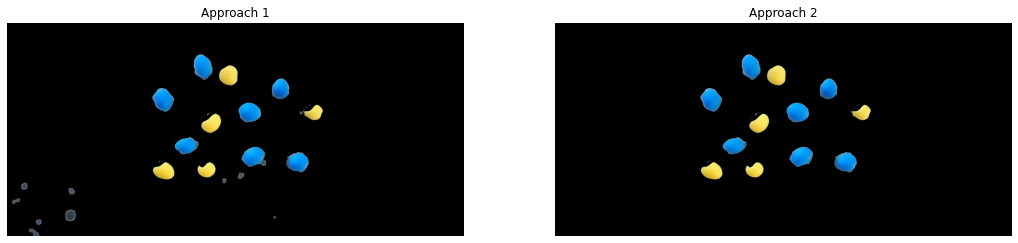

_________________________________________________________________________________________________________________________________

Image 2


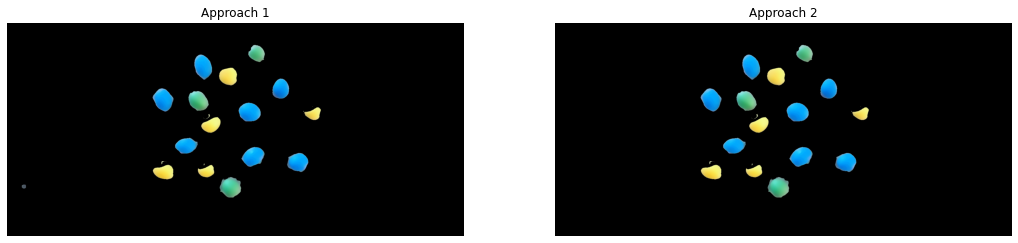

_________________________________________________________________________________________________________________________________

Image 3


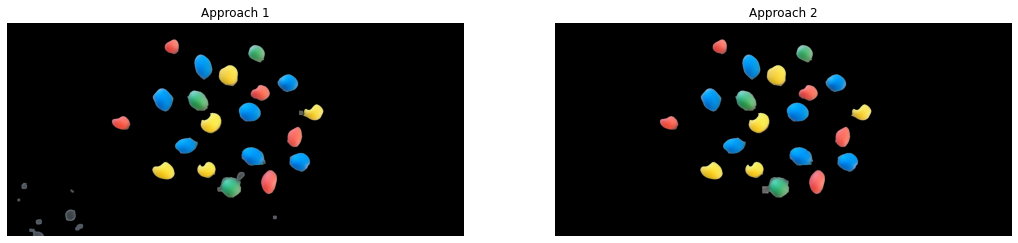

_________________________________________________________________________________________________________________________________

Image 4


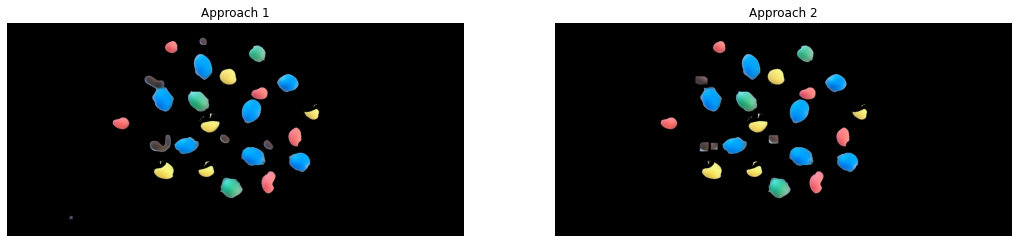

_________________________________________________________________________________________________________________________________

Image 5


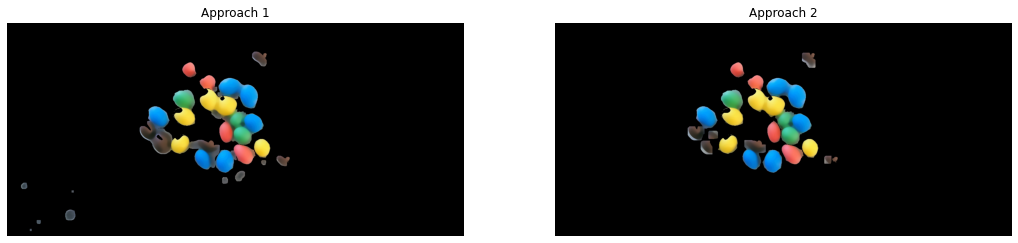

_________________________________________________________________________________________________________________________________



In [47]:
img_without_grey_background = []
masks_data_grey_background = []                 # tuple with masks for each image (Red Mask, Green Mask, Blue Mask, Yellow Mask, Brown Mask)
masks_combined_data_grey_background = []        # list with mask of all m&m (independent of color)

#by funct
img_without_grey_background_by_func = []
masks_data_grey_background_by_func = []                
masks_combined_data_grey_background_by_func = []        

i = 1
for img_read in images_grey_back:
  #cv2_imshow(img_read)
  #print("\n")
  img = cv.bilateralFilter(img_read, 30, 100, 100)
  img = cv.medianBlur(img,19)  
  img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

  # Red
  mask_red_low = cv.inRange(img_hsv, lower_red, upper_red)
  mask_red_high = cv.inRange(img_hsv, lower_red_h, upper_red_h)
  # combine masks
  mask_red = cv.bitwise_or(mask_red_low, mask_red_high) 
  img_red = cv.bitwise_or(img_hsv, img_hsv, mask=mask_red)
  #cv2_imshow(img_red)

  # green
  mask_green = cv.inRange(img_hsv, lower_green, upper_green)
  img_green = cv.bitwise_and(img_hsv, img_hsv, mask=mask_green)
  #cv2_imshow(img_green)

  # blue
  mask_blue = cv.inRange(img_hsv, lower_blue, upper_blue)
  img_blue = cv.bitwise_and(img_hsv, img_hsv, mask=mask_blue)
  #cv2_imshow(img_blue)

  # yellow
  mask_yellow = cv.inRange(img_hsv, lower_yellow, upper_yellow)
  img_yellow = cv.bitwise_and(img_hsv, img_hsv, mask=mask_yellow)
  #cv2_imshow(img_yellow)

  # brown
  h, s, v = img_hsv[:,:,0], img_hsv[:,:,1], img_hsv[:,:,2]
  mask_brown = cv.threshold(v, 100, 255, cv.THRESH_BINARY_INV)[1]
  mask_brown = cv.dilate(mask_brown,kernel = np.ones((7,7),np.uint8),iterations = 1)
  #cv2_imshow(mask_brown)

  combined_masks = cv.bitwise_or(mask_blue, mask_red)
  combined_masks = cv.bitwise_or(combined_masks, mask_yellow) 
  combined_masks = cv.bitwise_or(combined_masks, mask_green)
  combined_masks_0 = cv.bitwise_or(combined_masks, mask_brown)
  
  print("Image", i)
  i += 1
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

  img_roi = cv.bitwise_and(img_hsv, img_hsv, mask=combined_masks_0)
  img_roi_bgr = cv.cvtColor(img_roi, cv.COLOR_HSV2BGR)
  img_roi_rgb = cv.cvtColor(img_roi_bgr, cv.COLOR_BGR2RGB)
  ax[0].imshow(img_roi_rgb)
  ax[0].axis('off')
  ax[0].set_title("Approach 1")
  #cv2_imshow(img_roi_bgr)
  #print("\n")

  img_without_grey_background.append(img_roi_bgr) 
  masks_data_grey_background.append((mask_red,mask_green,mask_blue,mask_yellow,mask_brown))
  masks_combined_data_grey_background.append(combined_masks_0)

  # From aproach 1 - "by_funct"
  mask_brown_by_funct = mask_brown_func(img)
  combined_masks_1 = cv.bitwise_or(combined_masks, ~mask_brown_by_funct)

  img_roi = cv.bitwise_and(img_hsv, img_hsv, mask=combined_masks_1)
  img_roi_bgr = cv.cvtColor(img_roi, cv.COLOR_HSV2BGR)
  img_roi_rgb = cv.cvtColor(img_roi_bgr, cv.COLOR_BGR2RGB)
  ax[1].imshow(img_roi_rgb)
  ax[1].axis('off')
  ax[1].set_title("Approach 2")
  #cv2_imshow(img_roi_bgr)
  #print("\n")

  plt.show()

  img_without_grey_background_by_func.append(img_roi_bgr) 
  masks_data_grey_background_by_func.append((mask_red,mask_green,mask_blue,mask_yellow,~mask_brown_by_funct))
  masks_combined_data_grey_background_by_func.append(combined_masks_1)

  print("_________________________________________________________________________________________________________________________________\n")

### **d II**. Calculate the color distribution (up to 4);


Image 1

Percentage of color in each channel using BGR model
Red: [30.92]% ; Green: [34.54]% ; Blue: [34.54]%


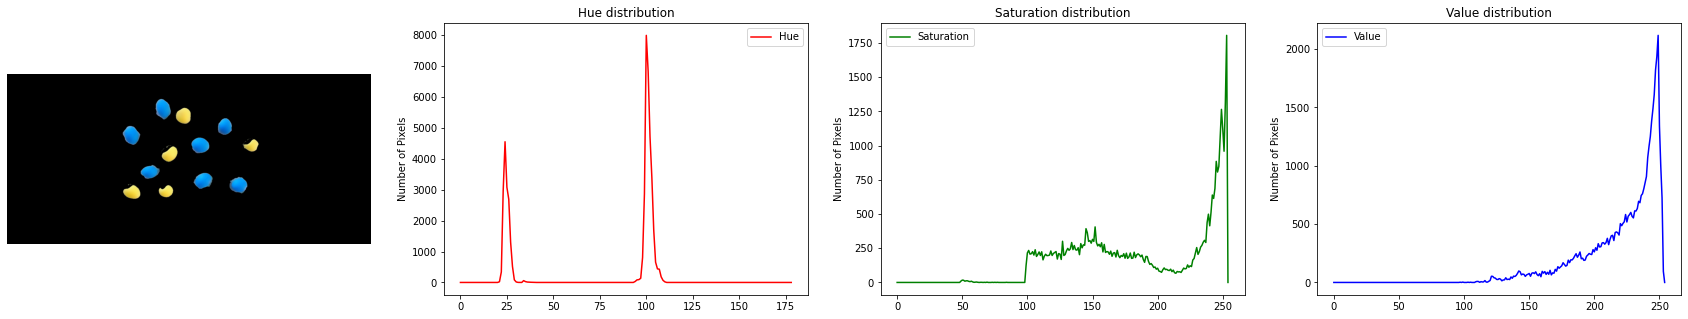

_________________________________________________________________________________________________________________________________


Image 2

Percentage of color in each channel using BGR model
Red: [31.69]% ; Green: [34.15]% ; Blue: [34.15]%


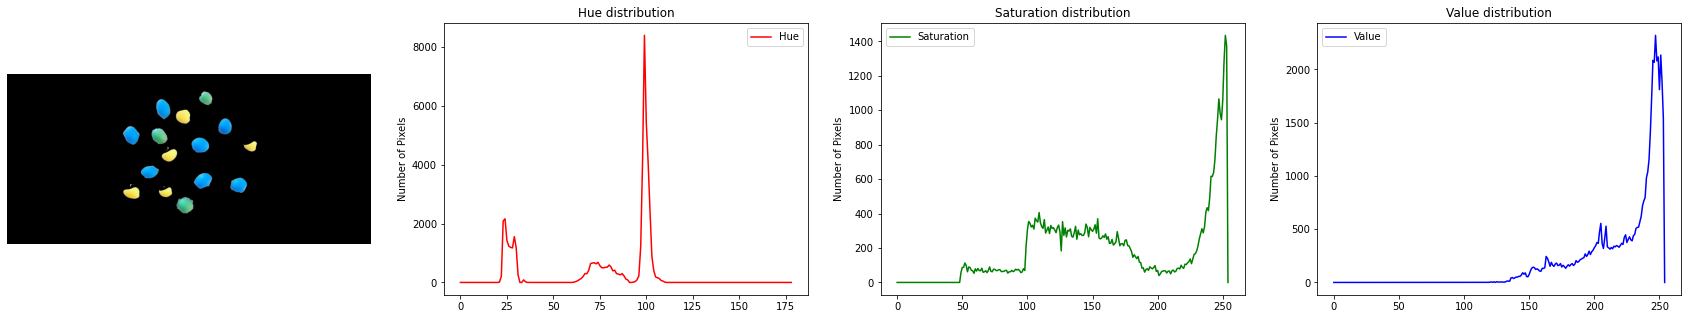

_________________________________________________________________________________________________________________________________


Image 3

Percentage of color in each channel using BGR model
Red: [32.01]% ; Green: [34.]% ; Blue: [34.]%


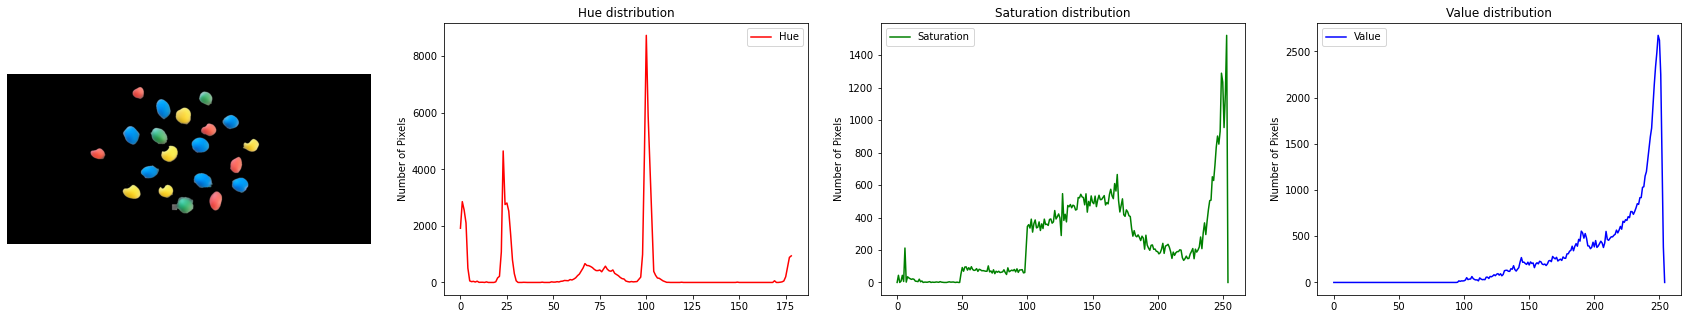

_________________________________________________________________________________________________________________________________


Image 4

Percentage of color in each channel using BGR model
Red: [31.86]% ; Green: [34.07]% ; Blue: [34.07]%


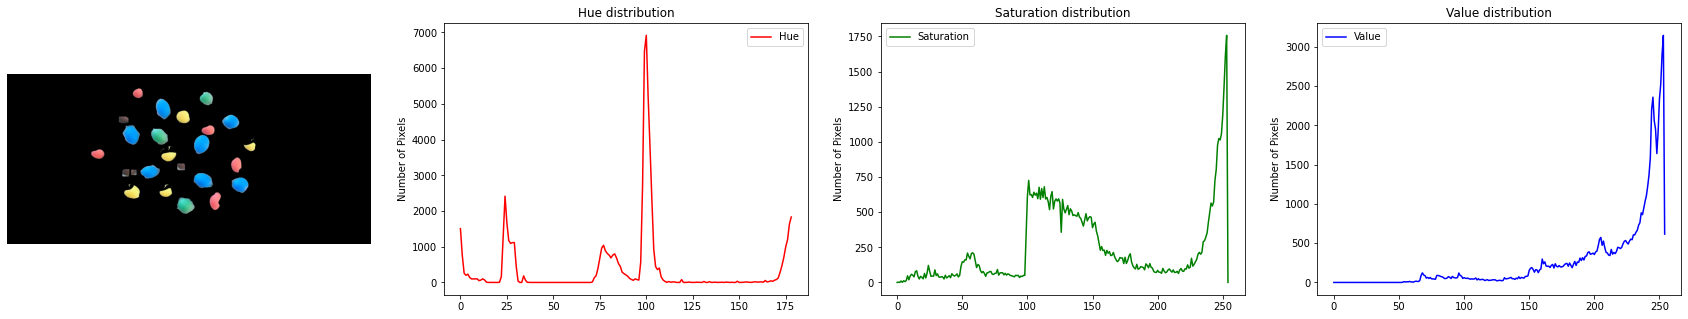

_________________________________________________________________________________________________________________________________


Image 5

Percentage of color in each channel using BGR model
Red: [31.81]% ; Green: [34.1]% ; Blue: [34.1]%


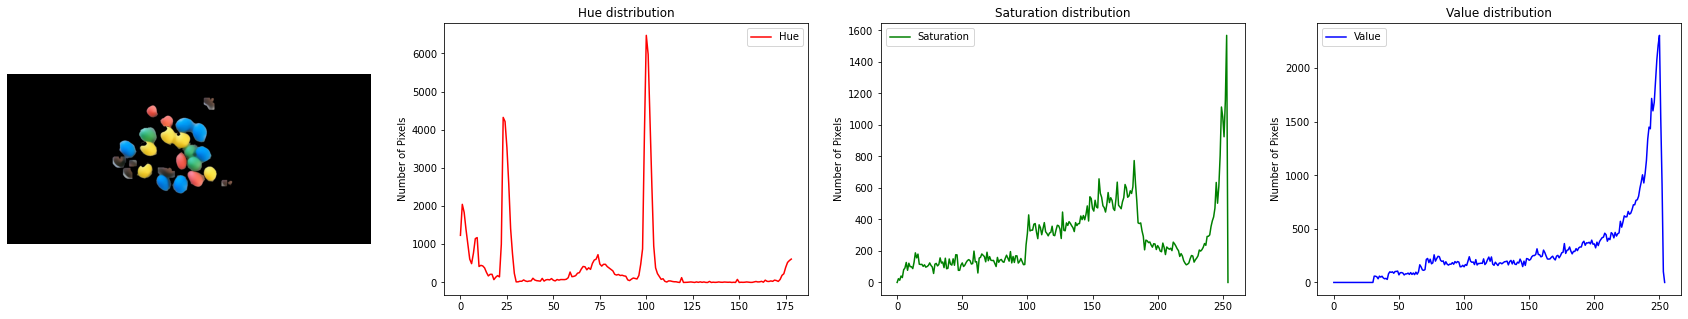

_________________________________________________________________________________________________________________________________



In [48]:
color_dist(img_without_grey_background_by_func)

### **d III**. Determine the shape area for the chocolate peanuts in pixels;

In [49]:
for image_index, i in enumerate(masks_combined_data_grey_background_by_func):
  print("Total shape area in pixel of chocolate peanuts in image {} = {}".format(image_index+1, np.int(np.sum(i)/255)))

Total shape area in pixel of chocolate peanuts in image 1 = 46098
Total shape area in pixel of chocolate peanuts in image 2 = 51381
Total shape area in pixel of chocolate peanuts in image 3 = 70715
Total shape area in pixel of chocolate peanuts in image 4 = 66657
Total shape area in pixel of chocolate peanuts in image 5 = 76886


### **d IV**. Determine the shape area for chocolate peanuts in millimeters and group by color;

The next bar plots show that the first approach is worse than the seccond. In the first one we are detecting brown in images that do not have brown M&M. 

Image 1
Area of Red (in mm²) = 0.0
Area of Green (in mm²) = 8.1
Area of Blue (in mm²) = 2070.8
Area of Yellow (in mm²) = 1059.98
Area of Brown (in mm²) = 324.59




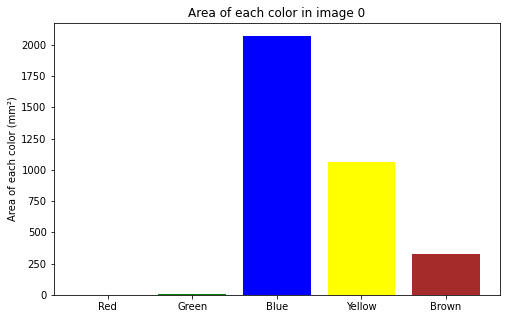

---------------------------------------------------------------

Image 2
Area of Red (in mm²) = 0.0
Area of Green (in mm²) = 749.21
Area of Blue (in mm²) = 1900.98
Area of Yellow (in mm²) = 849.17
Area of Brown (in mm²) = 12.32




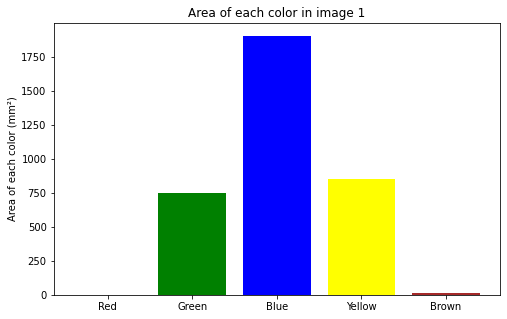

---------------------------------------------------------------

Image 3
Area of Red (in mm²) = 943.88
Area of Green (in mm²) = 772.77
Area of Blue (in mm²) = 1898.25
Area of Yellow (in mm²) = 1161.57
Area of Brown (in mm²) = 330.04




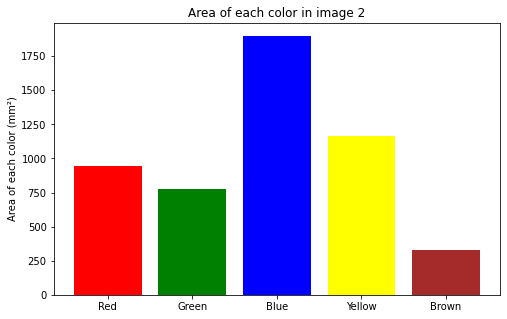

---------------------------------------------------------------

Image 4
Area of Red (in mm²) = 727.76
Area of Green (in mm²) = 738.31
Area of Blue (in mm²) = 2098.85
Area of Yellow (in mm²) = 719.11
Area of Brown (in mm²) = 482.56




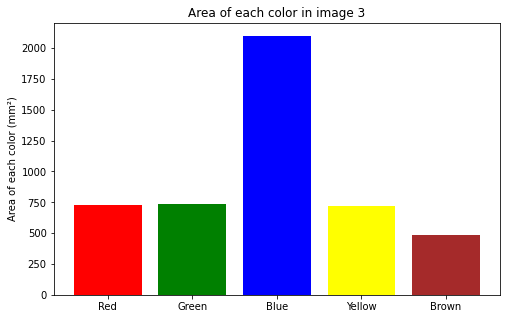

---------------------------------------------------------------

Image 5
Area of Red (in mm²) = 806.81
Area of Green (in mm²) = 756.02
Area of Blue (in mm²) = 1738.31
Area of Yellow (in mm²) = 1219.18
Area of Brown (in mm²) = 1646.11




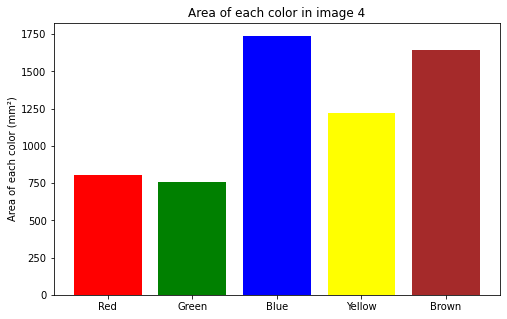

---------------------------------------------------------------



In [50]:
# From approach 1 in d I.
colors = ['Red', 'Green', 'Blue', 'Yellow', 'Brown']
shape_area_color(colors, masks_data_grey_background)

Image 1
Area of Red (in mm²) = 0.0
Area of Green (in mm²) = 8.1
Area of Blue (in mm²) = 2070.8
Area of Yellow (in mm²) = 1059.98
Area of Brown (in mm²) = 0.0




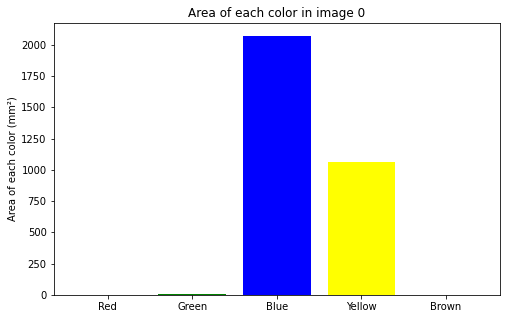

---------------------------------------------------------------

Image 2
Area of Red (in mm²) = 0.0
Area of Green (in mm²) = 749.21
Area of Blue (in mm²) = 1900.98
Area of Yellow (in mm²) = 849.17
Area of Brown (in mm²) = 0.0




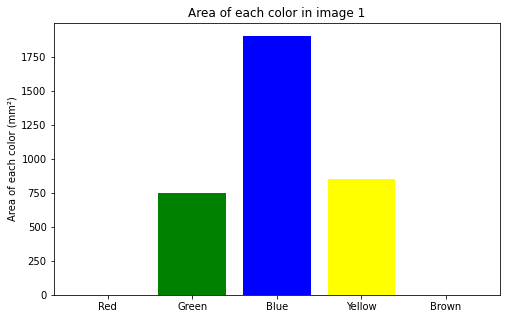

---------------------------------------------------------------

Image 3
Area of Red (in mm²) = 943.88
Area of Green (in mm²) = 772.77
Area of Blue (in mm²) = 1898.25
Area of Yellow (in mm²) = 1161.57
Area of Brown (in mm²) = 40.51




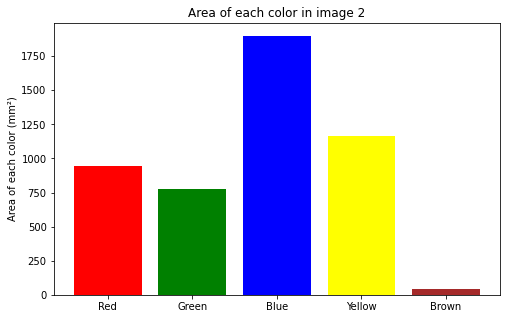

---------------------------------------------------------------

Image 4
Area of Red (in mm²) = 727.76
Area of Green (in mm²) = 738.31
Area of Blue (in mm²) = 2098.85
Area of Yellow (in mm²) = 719.11
Area of Brown (in mm²) = 265.08




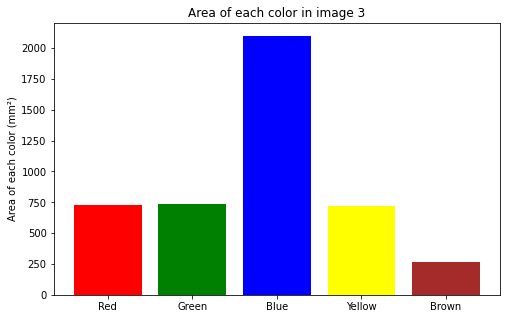

---------------------------------------------------------------

Image 5
Area of Red (in mm²) = 806.81
Area of Green (in mm²) = 756.02
Area of Blue (in mm²) = 1738.31
Area of Yellow (in mm²) = 1219.18
Area of Brown (in mm²) = 742.6




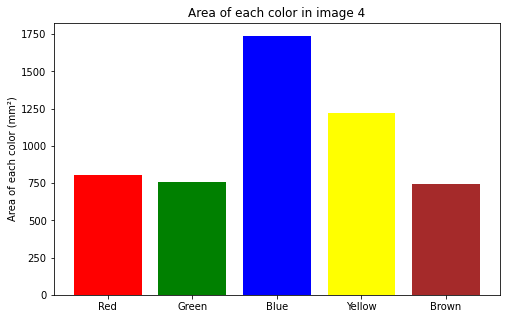

---------------------------------------------------------------



In [51]:
# From approach 2 in d I.
colors = ['Red', 'Green', 'Blue', 'Yellow', 'Brown']
shape_area_color(colors, masks_data_grey_background_by_func)

### **d V**. Show a histogram of the shape areas of the chocolate peanuts for the entire sample;

* The outputs presented are for the image with the best results. To change the image, just change image index in the next code cell. <br>
* We were not able to get good results for the image 5 (index_img = 4), which is the one that has M&Ms close together and also brown M&M. <br>
* We would like to have tried some other approaches that were not properly explored. For example, improving edge detection with Canny filter, as it was tested with the white background images and did not improve the results, but in the case of gray background images it might help improve results. Also the watershed algorithm could help to detect the components that are too close together (https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html). 



### Step 0

Entire sample image (undistorted):


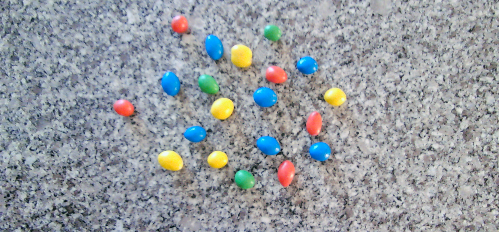

(775, 1663, 3) ; uint8

Entire sample image with mask:


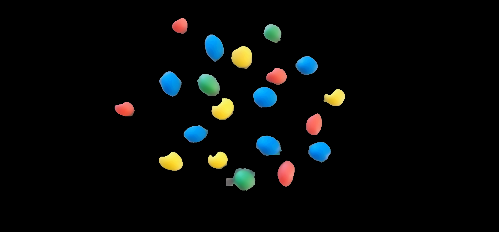

(775, 1663, 3) ; uint8

Mask of entire sample image:


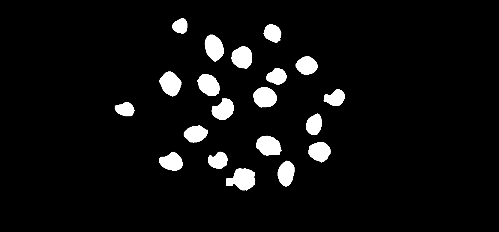

(775, 1663) ; uint8


In [52]:
index_img = 2   # from 0 to 4

entire_sample_image = images_grey_back[index_img].copy()
entire_sample_image_with_mask = img_without_grey_background_by_func[index_img].copy()
mask_of_entire_sample_image = masks_combined_data_grey_background_by_func[index_img].copy()

show_images(entire_sample_image, entire_sample_image_with_mask, mask_of_entire_sample_image)

### Step1

(775, 1663) ; int32


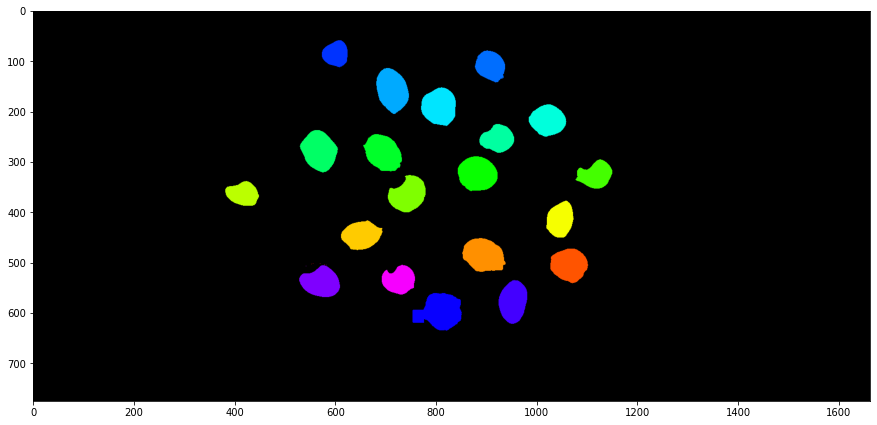

In [53]:
num_labels, labels_im = step1()

### Step2

In [54]:
label_groups = step2(num_labels, labels_im, threshold_label = 300)
#label_groups = step2(num_labels, labels_im, threshold_label = 500) # the threshold depends on the mask noise - use this to image 3

Count labels: 27
[[      0 1218110]
 [      1    2052]
 [      2    2765]
 [      3    4239]
 [      4    4074]
 [      5    3452]
 [      6    2772]
 [      7    4344]
 [      8    4098]
 [      9    4250]
 [     10    2769]
 [     11    3826]
 [     12    2378]
 [     13    2958]
 [     14    3434]
 [     15    4343]
 [     16    3816]
 [     17       1]
 [     18       1]
 [     19       1]
 [     20       1]
 [     21       1]
 [     22    2799]
 [     23       1]
 [     24    3591]
 [     25    3702]
 [     26    5047]] 

Count NEW labels: 21
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16, 17, 18, 19, 20, 21], [22, 23], [24], [25], [26]]


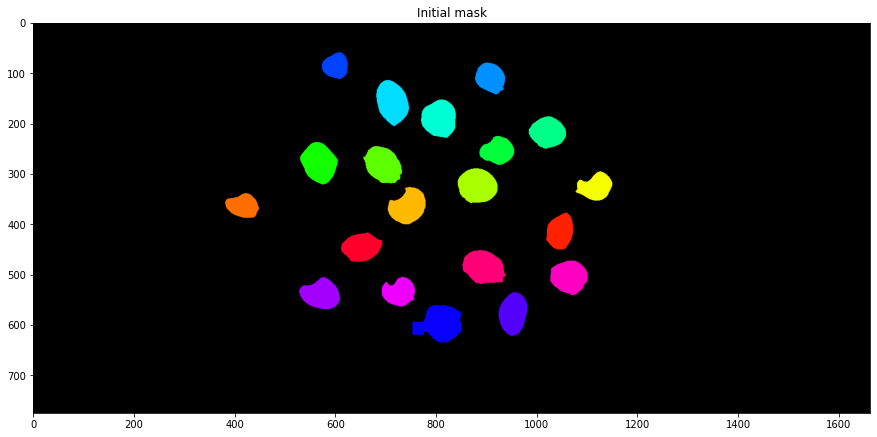

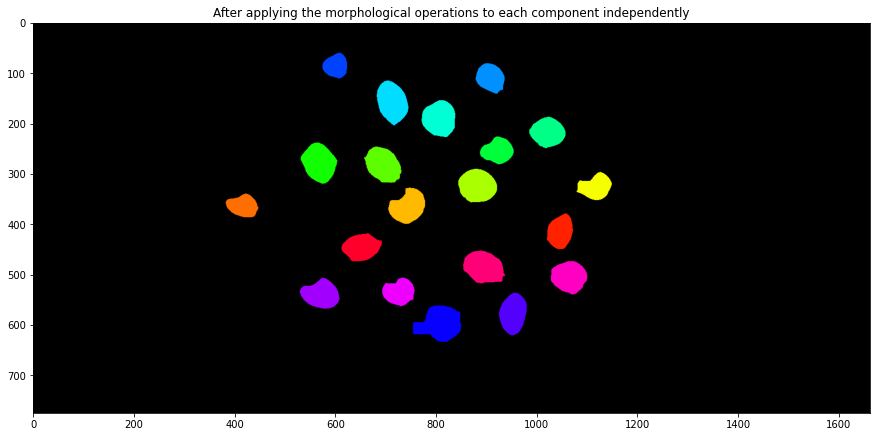

In [55]:
final_masks = step3(labels_im, label_groups, k2=3)

### Step4

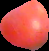

M&M 0
area: 111.67 mm²
color: red



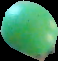

M&M 1
area: 172.07 mm²
color: green



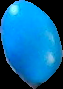

M&M 2
area: 267.67 mm²
color: blue



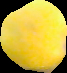

M&M 3
area: 257.79 mm²
color: yellow



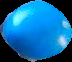

M&M 4
area: 216.46 mm²
color: blue



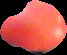

M&M 5
area: 157.63 mm²
color: red



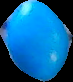

M&M 6
area: 274.34 mm²
color: blue



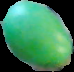

M&M 7
area: 259.29 mm²
color: green



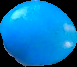

M&M 8
area: 269.51 mm²
color: blue



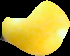

M&M 9
area: 172.41 mm²
color: yellow



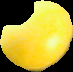

M&M 10
area: 242.27 mm²
color: yellow



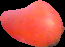

M&M 11
area: 137.41 mm²
color: red



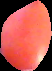

M&M 12
area: 169.34 mm²
color: red



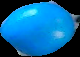

M&M 13
area: 215.03 mm²
color: blue



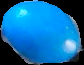

M&M 14
area: 275.29 mm²
color: blue



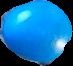

M&M 15
area: 240.63 mm²
color: blue



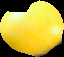

M&M 16
area: 177.17 mm²
color: yellow



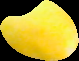

M&M 17
area: 225.18 mm²
color: yellow



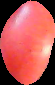

M&M 18
area: 212.1 mm²
color: red



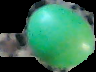

M&M 19
area: 323.57 mm²
color: green



In [56]:
info_peanuts =  step4()

### Step5

  Component    area_peanut_px    area_peanut_px_count    area_peanut_mm  color_peanut
-----------  ----------------  ----------------------  ----------------  --------------
          0            1777.5                    1640            111.67  red
          1            2443                      2527            172.07  green
          2            3829.5                    3931            267.67  blue
          3            3686.5                    3786            257.79  yellow
          4            3090                      3179            216.46  blue
          5            2441                      2315            157.63  red
          6            3929.5                    4029            274.34  blue
          7            3703.5                    3808            259.29  green
          8            3857                      3958            269.51  blue
          9            2443.5                    2532            172.41  yellow
         10            3455               

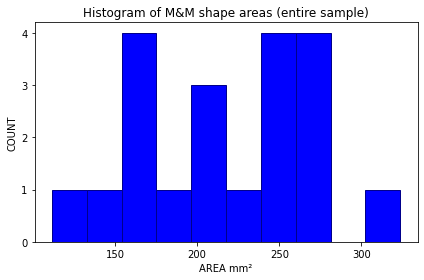

In [57]:
step5(info_peanuts)